Usamos los datos de la JODI Oil World Database (Joint Organisations Data Initiative [JODI], 2018). Que se obtiene de aqui: https://www.jodidata.org/oil/database/data-downloads.aspx

Fecha de descarga: 1 septiembre de 2020





# Prepare the Data Sets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# As the DB has country names referd by alpha-2-code I need to use pycountry to get actual names
#pip install pycountry
import pycountry 

#Read the csv files and build a pandas Dataframe
monthly = pd.read_csv("../Databases/JODI DB/world_Primary_CSV_NewFormat.csv")
monthly_second = pd.read_csv("../Databases/JODI DB/world_Secondary_CSV_NewFormat.csv")

monthly = pd.DataFrame(monthly)
monthly_second = pd.DataFrame(monthly_second)

In [2]:

# List of countries we are interested in
# Netos = ['Albania','Angola','Saudi Arabia','Algeria','Argentina','Benin','Azerbaijan','Bolivia (Plur. State of)','Brazil','Brunei Darussalam','Cameroon','Canada','China','Colombia','Congo','Denmark','Ecuador','Egypt','United Arab Emirates','Estonia','Gabon','Indonesia','Georgia','Ghana','Guatemala','Iran (Islamic Rep. of)','Iraq','Kazakhstan','Kyrgyzstan','Kuwait','Libya','Malaysia','Mexico','Mongolia','Myanmar','Nigeria','Norway','Oman','Qatar','United Kingdom','Dem. Rep. of the Congo','Russian Federation','Trinidad and Tobago','Sudan','South Sudan','Tunisia','Turkmenistan','Viet Nam','Venezuela (Bolivar. Rep.)','Yemen']

#While passing the code below we find that names from countries as Bolivia, Iran, DR Congo and Venezuela had different names so we have to manually addapt the names to "Bolivia, Plurinational State of", "Iran, Islamic Republic of", 'Congo, The Democratic Republic of the' and "Venezuela, Bolivarian Republic of"
netos = ['Albania','Angola','Saudi Arabia','Algeria','Argentina','Benin','Azerbaijan','Bolivia, Plurinational State of','Brazil','Brunei Darussalam','Cameroon','Canada','China','Colombia','Congo','Denmark','Ecuador','Egypt','United Arab Emirates','Estonia','Gabon','Indonesia','Georgia','Ghana','Guatemala','Iran, Islamic Republic of','Iraq','Kazakhstan','Kyrgyzstan','Kuwait','Libya','Malaysia','Mexico','Mongolia','Myanmar','Nigeria','Norway','Oman','Qatar','United Kingdom','Congo, The Democratic Republic of the','Russian Federation','Trinidad and Tobago','Sudan','South Sudan','Tunisia','Turkmenistan','Viet Nam','Venezuela, Bolivarian Republic of','Yemen']

#Create the same list with the alpha_2 code
a_codes = []
for x in netos:
    try:
        country = pycountry.countries.get(name=x)
        a_codes.append(country.alpha_2)
    except AttributeError:
        print(f'Theres an error with {x}')
        pass

#Check lenght
len(netos) - len(a_codes)

0

In [4]:
#### Identify which countries of interest are missing from the data set
# available = monthly["REF_AREA"].unique().tolist()

# for x in a_codes:
#     if x not in available:
#         country = pycountry.countries.get(alpha_2=x)
#         print(country.name)


#### On this data set there are no data for this countries:
# Benin
# Cameroon
# Congo
# Ghana
# Kyrgyzstan
# Mongolia
# Congo, The Democratic Republic of the
# South Sudan
# Turkmenistan

In [3]:
#Clean the DB from missing values
monthly = monthly.dropna(how="any")

#Filter the data base: show data only on Thousand Barrels per day (kb/d)(KBD)
dayly_barrels = monthly.loc[monthly["UNIT_MEASURE"] == "KBD"]

#Filter the data base: show data only from countries we are interested in
exportadores = dayly_barrels.loc[dayly_barrels["REF_AREA"].isin(a_codes)]

#divide the data set in three areas of interest crude oil, ngl and total
crude_oil = exportadores.loc[exportadores["ENERGY_PRODUCT"] == "CRUDEOIL"]
NGL = exportadores.loc[exportadores["ENERGY_PRODUCT"] == "NGL"]
total_crude = exportadores.loc[exportadores["ENERGY_PRODUCT"] == "TOTCRUDE"]

In [4]:
#Add the full country name column
#Create a function who get the name from alpha 2 encode
def country(x):
    pais = pycountry.countries.get(alpha_2=x)
    return pais.name
#Apply that function to the column REF_AREA in order to get the country column
crude_oil["Country"] = crude_oil["REF_AREA"].apply(lambda x : country(x))

#Filter data to get exports and imports in different datasets
imports = crude_oil.loc[crude_oil["FLOW_BREAKDOWN"] == "TOTIMPSB"]
exports = crude_oil.loc[crude_oil["FLOW_BREAKDOWN"] == "TOTEXPSB"]

In [5]:
#Rename values column
imports = imports.rename(columns={"OBS_VALUE" : "Imports (kb/d)", "ASSESSMENT_CODE" : "Imp_notes", "TIME_PERIOD" : "Month"})
exports = exports.rename(columns={"OBS_VALUE" : "Exports (kb/d)", "ASSESSMENT_CODE" : "Exp_notes", "TIME_PERIOD" : "Month"})

#drop unecesary data columns 
imports = imports.drop(columns=["ENERGY_PRODUCT", "FLOW_BREAKDOWN", "UNIT_MEASURE", "REF_AREA"]) 
exports = exports.drop(columns=["ENERGY_PRODUCT", "FLOW_BREAKDOWN", "UNIT_MEASURE", "REF_AREA"])

In [6]:
#Merge both datasets in one
exp_netas = exports.merge(imports, how="left", on=["Country", "Month"])
#Reorder the columns
exp_netas = exp_netas[['Country','Month', 'Exports (kb/d)','Exp_notes','Imports (kb/d)', 'Imp_notes']]
#Create a column who substract imports from Exports
exp_netas["Net Exports"] = (exp_netas["Exports (kb/d)"] - exp_netas["Imports (kb/d)"])

In [32]:
exp_netas.head()

,Country,Month,Exports (kb/d),Exp_notes,Imports (kb/d),Imp_notes,Net Exports
0,United Arab Emirates,2002-01,1860.0,3,0.0,3,1860.0
1,United Arab Emirates,2002-02,1989.0,3,0.0,3,1989.0
2,United Arab Emirates,2002-03,1868.0,3,0.0,3,1868.0
3,United Arab Emirates,2002-04,1669.0,3,0.0,3,1669.0
4,United Arab Emirates,2002-05,1821.0,3,0.0,3,1821.0


# Exportaciones netas por pais 

In [33]:
#Create a final pivot table for visual analysis of net exports 
netas_mensuales = exp_netas.pivot_table("Net Exports", ["Country"], "Month")
netas_mensuales.head()

Month,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,...,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06
Country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,...,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Algeria,364.0000,403.0000,364.0000,419.0000,419.0000,482.0000,428.000,405.0000,463.000,486.0000,...,511.000,562.0000,470.0000,528.0000,491.0000,418.0000,395.0000,434.0000,377.0000,0.000
Angola,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,821.0758,...,1009.000,998.0000,1090.0000,1185.0000,1236.0000,1161.0000,1341.0000,1110.0000,1026.0000,1084.000
Argentina,243.3226,242.1071,212.3226,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,...,60.900,82.7742,65.0000,53.3226,34.0968,37.7931,50.4516,132.5333,132.0968,0.000
Azerbaijan,179.0197,185.3029,188.7671,171.9667,152.3926,154.5243,175.929,189.2426,187.935,181.6348,...,560.857,540.3874,544.3973,561.5465,540.3874,535.7228,539.6742,575.5970,469.5403,453.255


In [47]:
exp_netas.plot(Country kind='line')
plt.show()


SyntaxError: invalid syntax (<ipython-input-47-c9c09c803432>, line 1)

# Exportaciones vs Importaciones totales

In [34]:
exportaciones_mensuales = exp_netas.pivot_table("Exports (kb/d)", ["Country"], "Month")
exportaciones_mensuales = exportaciones_mensuales.sum()

importaciones_mensuales = exp_netas.pivot_table("Imports (kb/d)", ["Country"], "Month")
importaciones_mensuales = importaciones_mensuales.sum()


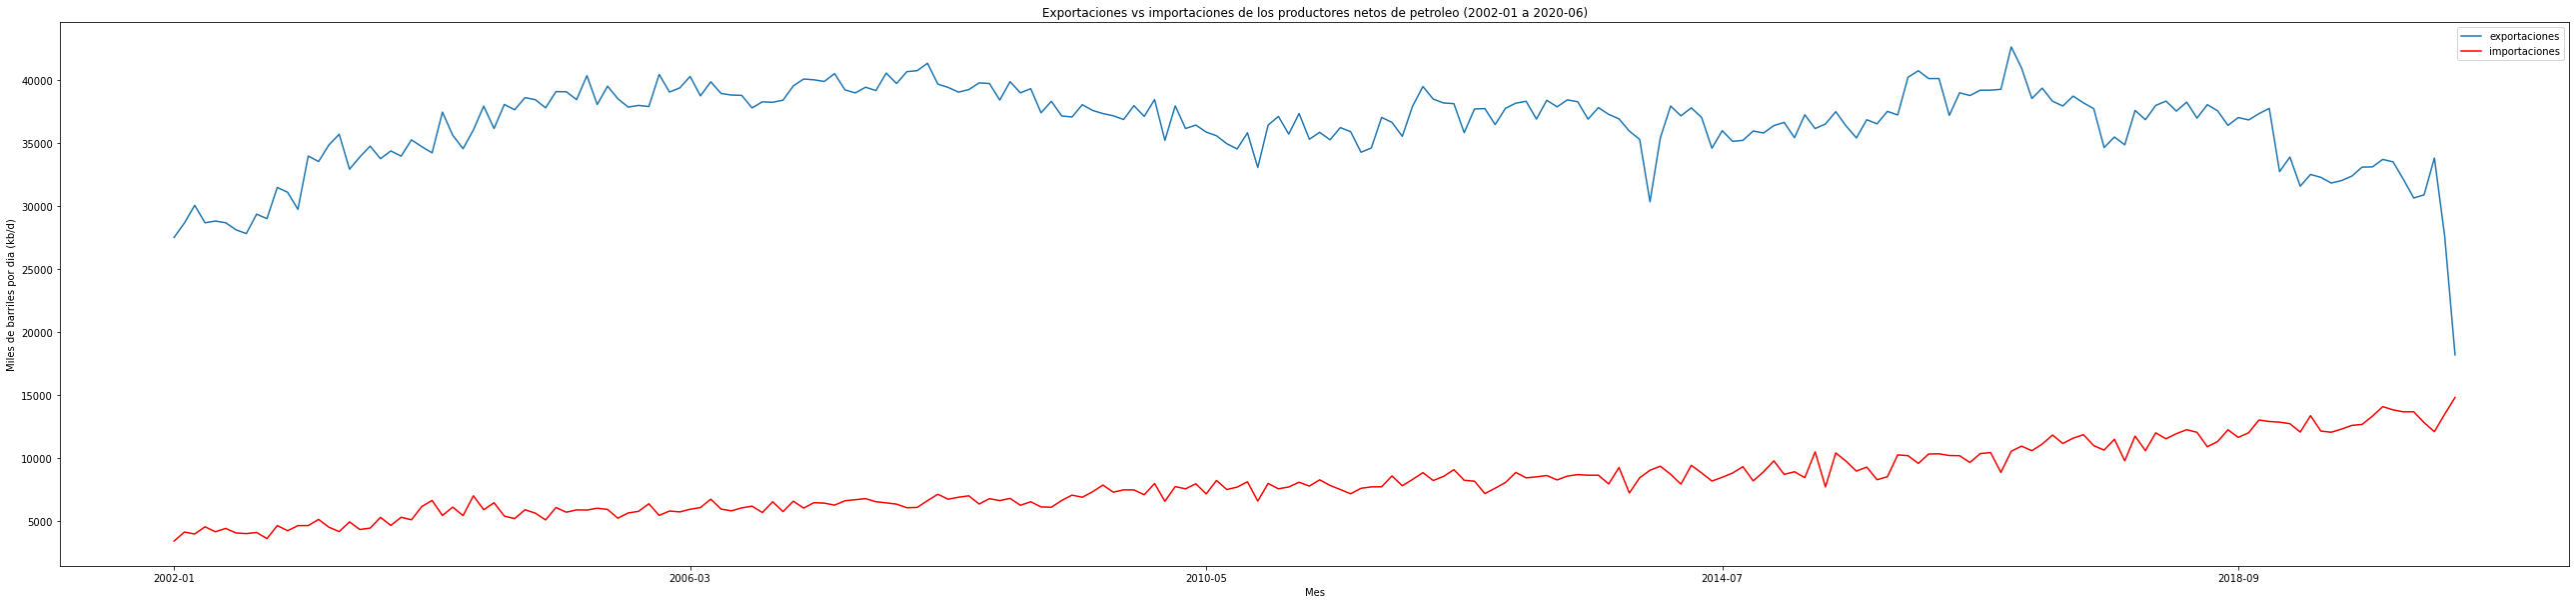

In [40]:
exportaciones_mensuales.plot(kind='line',  figsize=(45,10), label='Exportaciones') 
importaciones_mensuales.plot(kind='line', color='red', figsize=(45,10), label='Importaciones')

plt.title("Exportaciones vs importaciones de los productores netos de petroleo (2002-01 a 2020-06)")
plt.xlabel("Mes")
plt.ylabel("Miles de barriles por dia (kb/d)")

plt.legend( loc="best")

plt.show()

# Exportaciones totales netas mensuales

In [14]:
#Suma de totales mensuales
totales = netas_mensuales.sum()

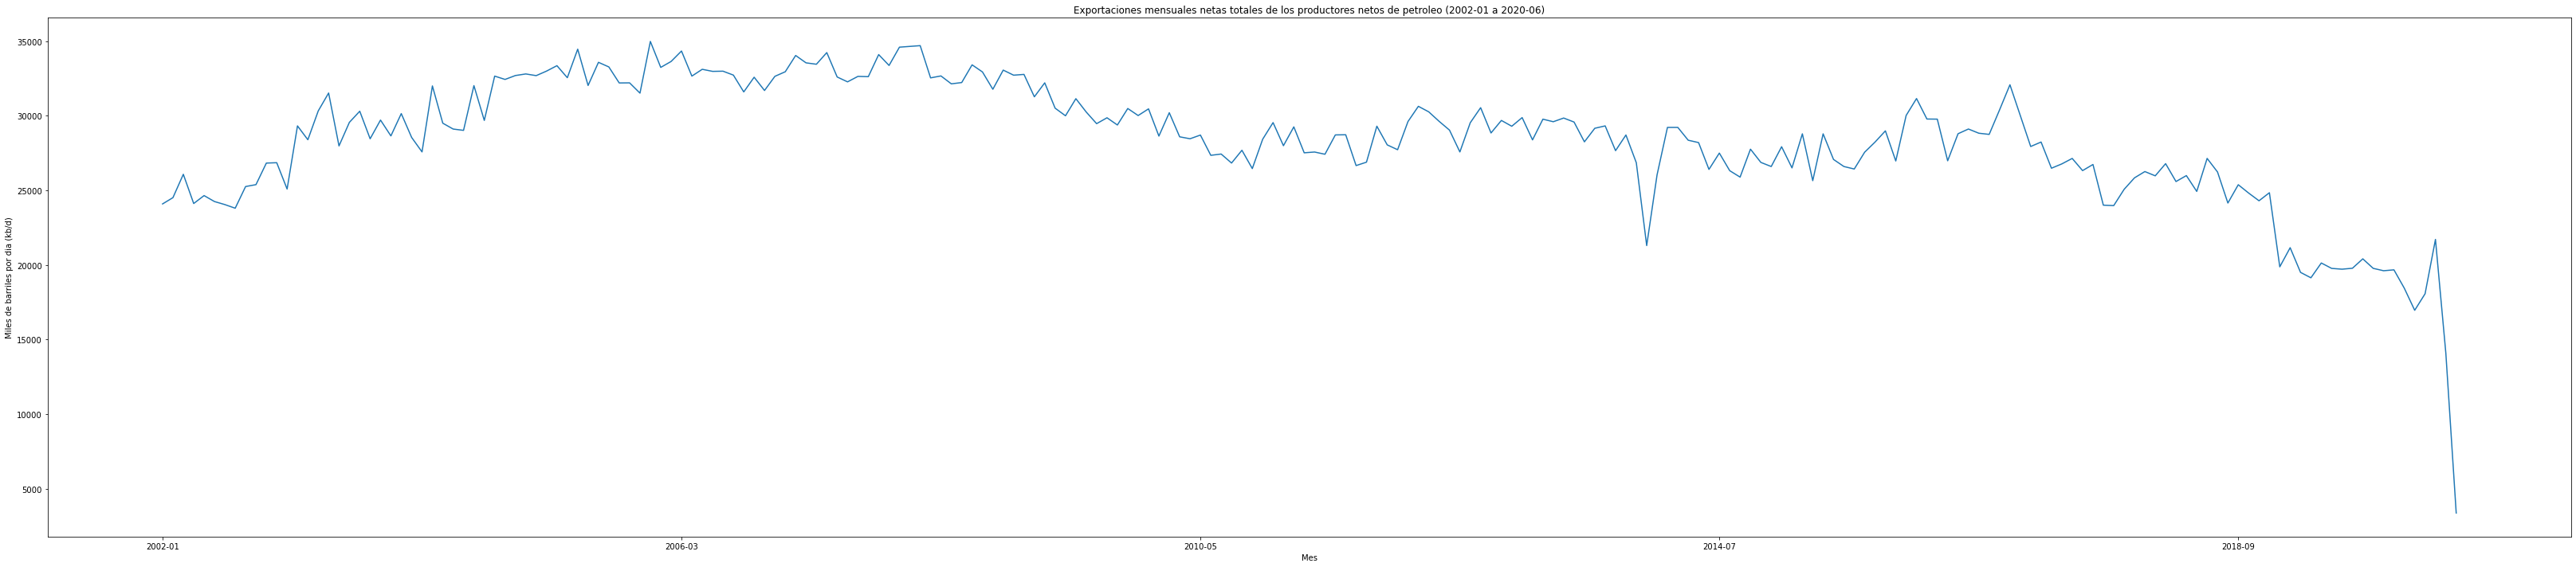

In [30]:
exportaciones_netas_totales = totales.plot(kind='line', figsize=(45,10))
plt.title("Exportaciones mensuales netas totales de los productores netos de petroleo (2002-01 a 2020-06)")
plt.xlabel("Mes")
plt.ylabel("Miles de barriles por dia (kb/d)")
plt.tight_layout()
plt.show()

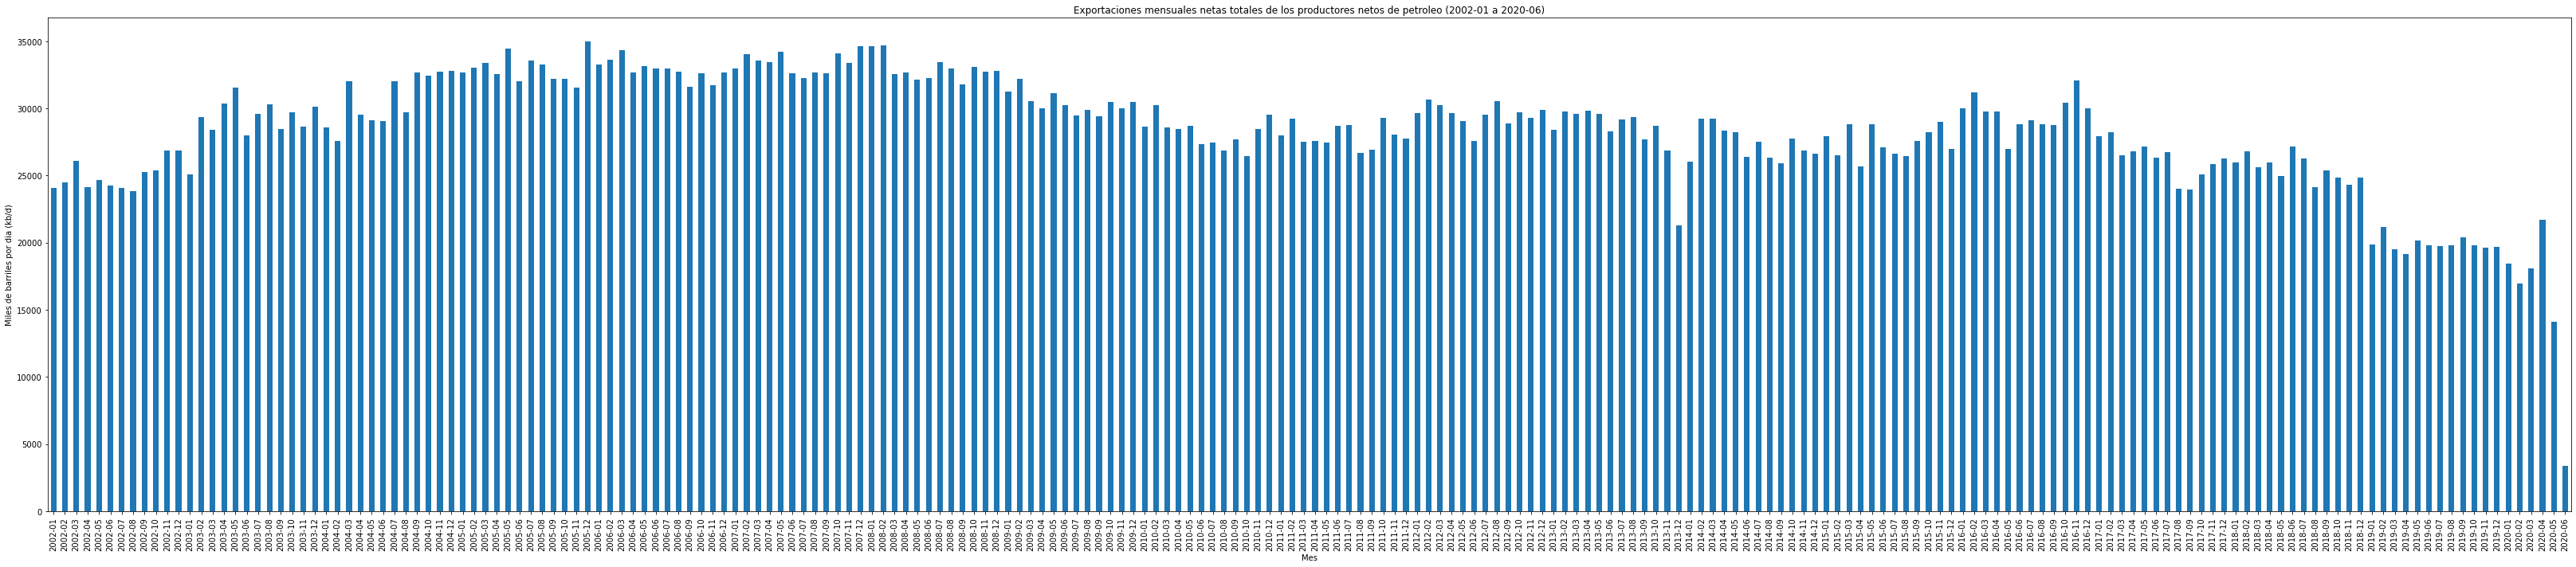

In [31]:
exportaciones_netas_totales = totales.plot(kind='bar', figsize=(45,10))
plt.title("Exportaciones mensuales netas totales de los productores netos de petroleo (2002-01 a 2020-06)")
plt.xlabel("Mes")
plt.ylabel("Miles de barriles por dia (kb/d)")
plt.tight_layout()
plt.show()

In [8]:
#Excel Report
# netas_mensuales.to_excel('../Excel_reports/Exp_netas_mensuales.xlsx')